# HR-Analytics Dataset for Machine Learning

## I. Data Acquisition

In [0]:
# import needed libraries 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from pylab import fill_between
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.optimizers import Adam, RMSprop

Using TensorFlow backend.


In [0]:
# import HR csv file
df=pd.read_csv('HR.csv')

### Plotting Functions

In [0]:
def plotTrainingHist(history, epoch, regType):
  plt.figure(figsize=(15,8))
  plt.plot(history.history['acc'])
  plt.plot(history.history['loss'])
  plt.ylim(0,1)
  plt.xlim(0, epoch-1)
  plt.xlabel('Epoch')
  plt.legend(['Accuracy', 'Loss'], loc='upper left')
  plt.title(regType + ': Accuracy:' + str(round(np.mean(history.history['acc']),2)) + ' ' + 'Loss:'+ str(round(np.mean(history.history['loss']),2)), fontsize=14)
  plt.show()

def confMatrix(X_test, y_test, model, regType):
  y_pred1 = model.predict(X_test)
  y_pred = y_pred1.round(0)
  print(classification_report(y_test, y_pred))
  f, ax = plt.subplots(figsize=(13,8))
  model_y_pred1 = model.predict(X_test, verbose=1)
  model_y_pred= model_y_pred1.round(0)
  model_cm = confusion_matrix(y_test,model_y_pred,[0,1])
  sns.heatmap(model_cm, annot=True, fmt='g', cmap="RdBu", xticklabels = ["0", "1"] , yticklabels = ["0", "1"], ax=ax )
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title(regType + ' : Confusion Matrix', fontsize=20)

def classReport(X_test, y_test, model):
  y_pred1 = model.predict(X_test)
  y_pred = y_pred1.round(0)
  print(classification_report(y_test, y_pred))


In [0]:
# Styles for Plotting # 
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

## II. Data Cleaning & Preprocessing

In [0]:
# query the first few tuples / rows in the dataset
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.56,0.89,4,263,3,0,0,0,accounting,low
1,0.91,0.94,5,159,3,0,0,0,technical,low
2,0.36,0.95,6,276,2,0,0,0,support,low
3,0.56,0.59,4,164,3,0,0,1,support,medium
4,0.77,0.73,3,201,10,0,0,0,management,high


In [0]:
# get the following information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12999 entries, 0 to 12998
Data columns (total 10 columns):
satisfaction_level       12999 non-null float64
last_evaluation          12999 non-null float64
number_project           12999 non-null int64
average_montly_hours     12999 non-null int64
time_spend_company       12999 non-null int64
Work_accident            12999 non-null int64
left                     12999 non-null int64
promotion_last_5years    12999 non-null int64
department               12999 non-null object
salary                   12999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1015.6+ KB


In this case, we can see the following data types available as well as if the values of the attributes are nullable or not.

In [0]:
# describe the data based on the mean, std, percentage quantile
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,12999.000000,12999.000000,12999.000000,12999.000000,12999.000000,12999.000000,12999.00000,12999.000000
mean,0.612192,0.715737,3.803985,200.804600,3.492038,0.144934,0.23848,0.021540
std,0.248819,0.171194,1.235239,50.053009,1.449327,0.352048,0.42617,0.145182
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.00000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.00000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.00000,0.000000
75%,0.810000,0.870000,5.000000,245.000000,4.000000,0.000000,0.00000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.00000,1.000000


The Pandas method describe generates a descriptive statistics that summarize the central tendency, dispersion and shape of the dataset.

**The following information have been gathered:**
1. Around 24% of the employees left the company.
2. The satisfaction level is around 62% and performance level is around 72%.
3. Employees who are working in average on 4 projects with 200 hours worked per month.

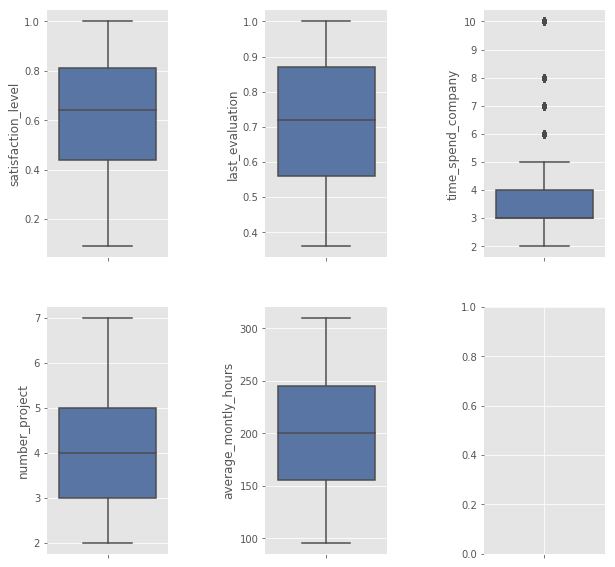

In [0]:
# check if there are necessary outliers in the given dataset 
f, axes = plt.subplots(2,3, figsize=(10,10),sharex=True)

plt.subplots_adjust(wspace=0.8)# adjust the space between the plots
sns.despine(left=True)

# form boxplots for the attributes to check for the distribution and if there are necessary outliers
sns.boxplot( x= 'satisfaction_level',  data=df, palette="deep", orient='v',ax=axes[0,0])
sns.boxplot( x= 'last_evaluation',  data=df,  palette="deep", orient='v',ax=axes[0,1])
sns.boxplot( x= 'time_spend_company',  data=df,  palette="deep", orient='v',ax=axes[0,2])
sns.boxplot( x= 'number_project',  data=df,  palette="deep", orient='v',ax=axes[1,0])
sns.boxplot( x= 'average_montly_hours',  data=df,  palette="deep", orient='v',ax=axes[1,1]);

**As a summary to the following boxplots above, we can derive the following:**

1.   Satisfaction level and Last evaluation has a skewed left (negative)
2.   Number of projects has a skewed right(positive)ditribution.
3.   Average monthly hours has a simetric ditribution.
4.   Time spend in the company attribute exhibits some outliers. 

### Correlation

In [0]:
df.corr()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
satisfaction_level,1.000000,0.100253,-0.142506,-0.023135,-0.105803,0.061682,-0.389471,0.024633
last_evaluation,0.100253,1.000000,0.350715,0.340343,0.130244,-0.010975,0.007410,-0.009429
number_project,-0.142506,0.350715,1.000000,0.417533,0.196164,-0.006494,0.022893,-0.012491
average_montly_hours,-0.023135,0.340343,0.417533,1.000000,0.130351,-0.010430,0.071808,-0.005794
time_spend_company,-0.105803,0.130244,0.196164,0.130351,1.000000,-0.003016,0.145570,0.068092
Work_accident,0.061682,-0.010975,-0.006494,-0.010430,-0.003016,1.000000,-0.157065,0.038261
left,-0.389471,0.007410,0.022893,0.071808,0.145570,-0.157065,1.000000,-0.060648
promotion_last_5years,0.024633,-0.009429,-0.012491,-0.005794,0.068092,0.038261,-0.060648,1.000000


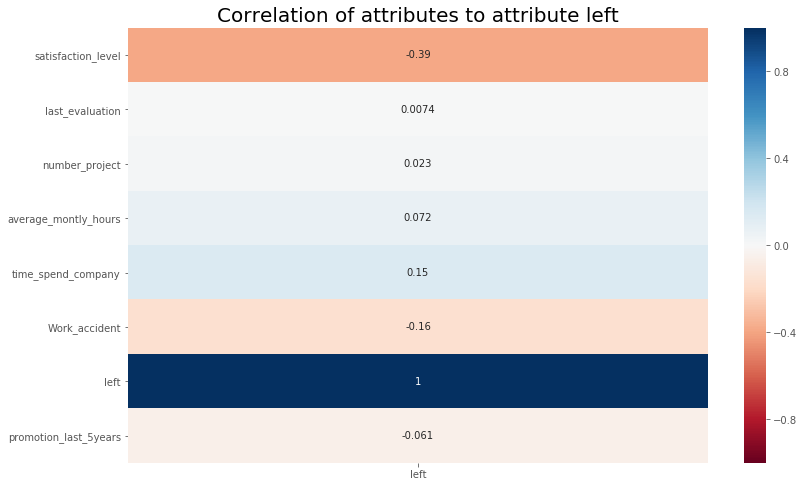

In [0]:
f, ax = plt.subplots(figsize=(13,8))
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)

ax = sns.heatmap(df.corr()[['left']], annot=True, vmin=-1, vmax=1, cmap="RdBu", ax=ax)
ax.set_title('Correlation of attributes to attribute left', fontsize=20);

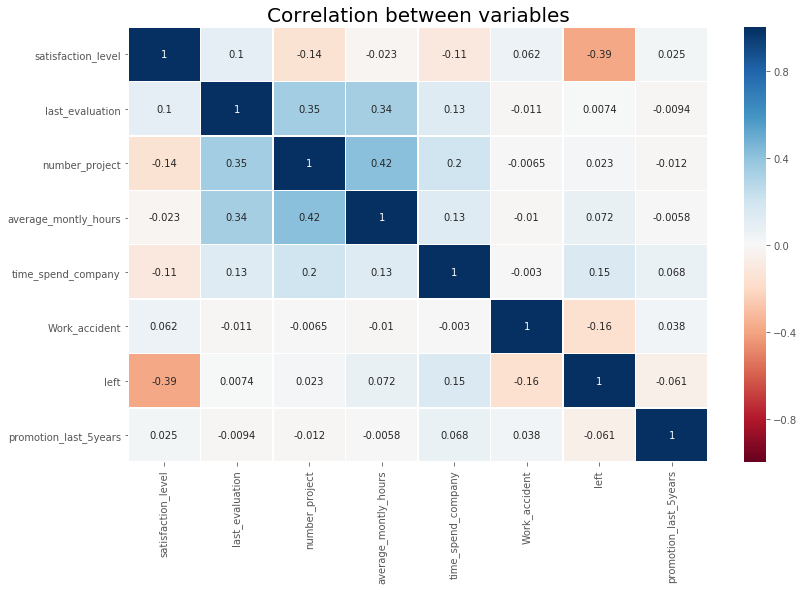

In [0]:
#sns.heatmap(df.corr(),cmap=cmap)
f, ax = plt.subplots(figsize=(13,8))
ax = sns.heatmap(df.corr(),cmap="RdBu", annot=True, xticklabels=True, yticklabels=True, linewidths=.5, vmin=-1, vmax=1, ax=ax)
ax.set_title('Correlation between variables', fontsize=20);

In [1]:
# plotting the histogram of the current data set to view the distribution
df.hist(bins=10, figsize=(20,15),color='blue')
plt.show()

NameError: ignored

In [0]:
ss = StandardScaler()
scale_features = ['average_montly_hours', 'number_project', 'time_spend_company']
df[scale_features] = ss.fit_transform(df[scale_features])

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [0]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,12999.000000,12999.000000,1.299900e+04,1.299900e+04,1.299900e+04,12999.000000,12999.00000,12999.000000
mean,0.612192,0.715737,5.739441e-17,-1.557848e-16,1.361067e-16,0.144934,0.23848,0.021540
std,0.248819,0.171194,1.000038e+00,1.000038e+00,1.000038e+00,0.352048,0.42617,0.145182
min,0.090000,0.360000,-1.460490e+00,-2.093953e+00,-1.029509e+00,0.000000,0.00000,0.000000
25%,0.440000,0.560000,-6.508989e-01,-8.951774e-01,-3.395071e-01,0.000000,0.00000,0.000000
50%,0.640000,0.720000,1.586920e-01,-1.607558e-02,-3.395071e-01,0.000000,0.00000,0.000000
75%,0.810000,0.870000,9.682830e-01,8.830058e-01,3.504949e-01,0.000000,0.00000,0.000000
max,1.000000,1.000000,2.587465e+00,2.181679e+00,4.490507e+00,1.000000,1.00000,1.000000


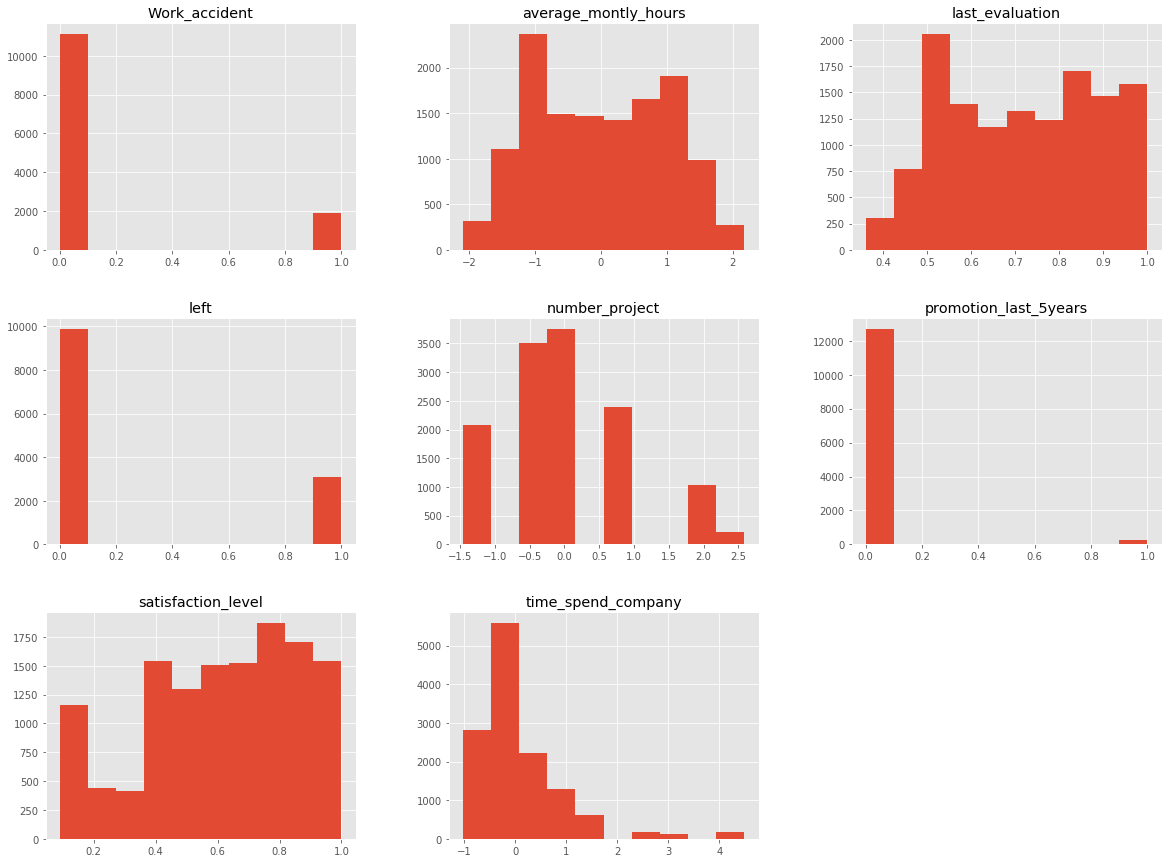

In [0]:
# plotting the histogram of the current data set to view the distribution
df.hist(bins=10, figsize=(20,15))
plt.show()

In [0]:
categorical_features = ['department','salary']
df_cat = pd.get_dummies(df[categorical_features])
df = df.drop(categorical_features, axis=1)
df = pd.concat ([df, df_cat], axis=1)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12999 entries, 0 to 12998
Data columns (total 21 columns):
satisfaction_level        12999 non-null float64
last_evaluation           12999 non-null float64
number_project            12999 non-null float64
average_montly_hours      12999 non-null float64
time_spend_company        12999 non-null float64
Work_accident             12999 non-null int64
left                      12999 non-null int64
promotion_last_5years     12999 non-null int64
department_IT             12999 non-null uint8
department_RandD          12999 non-null uint8
department_accounting     12999 non-null uint8
department_hr             12999 non-null uint8
department_management     12999 non-null uint8
department_marketing      12999 non-null uint8
department_product_mng    12999 non-null uint8
department_sales          12999 non-null uint8
department_support        12999 non-null uint8
department_technical      12999 non-null uint8
salary_high               12999 non

Feature 'salary' has now been divided categorically.

In [0]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.56,0.89,0.158692,1.242638,-0.339507,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,0.91,0.94,0.968283,-0.835239,-0.339507,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,0.36,0.95,1.777874,1.502373,-1.029509,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,0.56,0.59,0.158692,-0.735341,-0.339507,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
4,0.77,0.73,-0.650899,0.003904,4.490507,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [0]:
salary = ['salary_high','salary_low','salary_medium']
df[salary].head()

,salary_high,salary_low,salary_medium
0,0,1,0
1,0,1,0
2,0,1,0
3,0,0,1
4,1,0,0


## Creating the Training and Test Data

In [0]:
X = df.drop ('left', axis=1).values
y = df['left'].values
X_train, X_test , y_train , y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [0]:
X_train

array([[ 0.55      ,  0.66      , -0.65089893, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.61      ,  0.5       ,  0.15869204, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.57      ,  0.48      ,  0.968283  , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.41      ,  0.47      , -1.4604899 , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.43      ,  0.5       , -1.4604899 , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.86      ,  0.73      , -0.65089893, ...,  0.        ,
         1.        ,  0.        ]])

In [0]:
X_test

array([[ 0.92      ,  0.78      ,  0.968283  , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.97      ,  0.81      , -0.65089893, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.64      ,  0.64      , -0.65089893, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.97      ,  0.63      ,  0.968283  , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.51      ,  0.5       ,  0.968283  , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.33      ,  0.69      , -0.65089893, ...,  0.        ,
         0.        ,  1.        ]])

In [0]:
y_train

array([0, 0, 0, ..., 1, 1, 0])

In [0]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

*Insert Notes abouts train_test_split* here

## Logistic Regression Model

In [0]:
lr_model = Sequential()
lr_model.add(Dense(1,input_shape=(X_train.shape[1],),activation='sigmoid'))
lr_model.compile(Adam(lr =0.01),'binary_crossentropy',metrics=['accuracy'])
lr_history = lr_model.fit(X_train, y_train, verbose=1, epochs=30)
#plot_loss_accuracy(lr_history)

W0130 13:36:42.137032 139988296718208 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0130 13:36:42.149342 139988296718208 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0130 13:36:42.157783 139988296718208 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0130 13:36:42.182133 139988296718208 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0130 13:36:42.188312 139988296718208 module_wrapper.py:139] From /usr/local

Epoch 1/30


W0130 13:36:42.649523 139988296718208 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



9099/9099 [==============================] - 1s 92us/step - loss: 0.5201 - acc: 0.7401
Epoch 2/30
9099/9099 [==============================] - 0s 35us/step - loss: 0.4664 - acc: 0.7577
Epoch 3/30
9099/9099 [==============================] - 0s 32us/step - loss: 0.4499 - acc: 0.7661
Epoch 4/30
9099/9099 [==============================] - 0s 36us/step - loss: 0.4430 - acc: 0.7712
Epoch 5/30
9099/9099 [==============================] - 0s 33us/step - loss: 0.4397 - acc: 0.7754
Epoch 6/30
9099/9099 [==============================] - 0s 33us/step - loss: 0.4386 - acc: 0.7790
Epoch 7/30
9099/9099 [==============================] - 0s 33us/step - loss: 0.4383 - acc: 0.7828
Epoch 8/30
9099/9099 [==============================] - 0s 33us/step - loss: 0.4380 - acc: 0.7809
Epoch 9/30
9099/9099 [==============================] - 0s 32us/step - loss: 0.4383 - acc: 0.7827
Epoch 10/30
9099/9099 [==============================] - 0s 32us/step - loss: 0.4378 - acc: 0.7831
Epoch 11/30
9099/9099 [=======

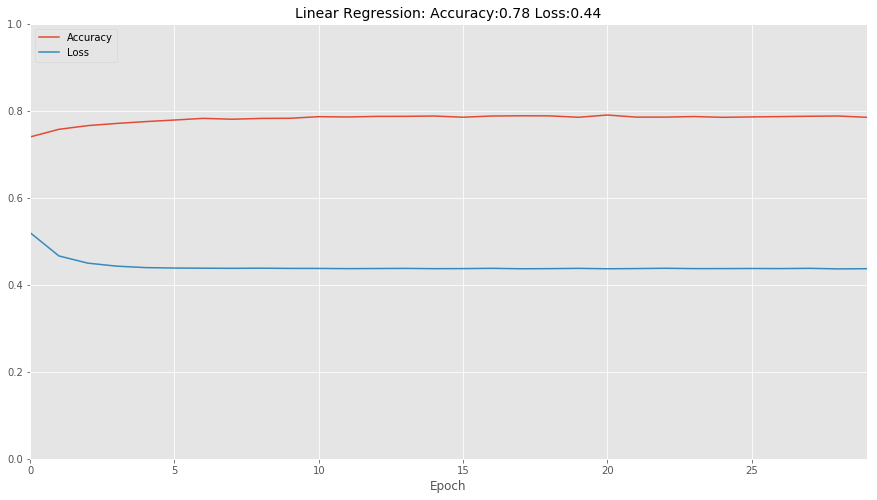

In [0]:
# summarize history for accuracy
plotTrainingHist(lr_history, 30,'Linear Regression')

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      2976
           1       0.66      0.47      0.55       924

   micro avg       0.82      0.82      0.82      3900
   macro avg       0.75      0.70      0.72      3900
weighted avg       0.80      0.82      0.81      3900

3900/3900 [==============================] - 0s 13us/step


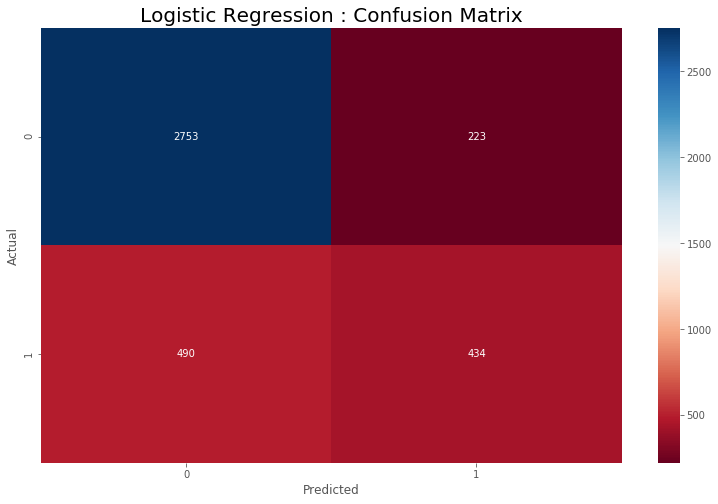

In [0]:
confMatrix(X_test, y_test, lr_model, 'Logistic Regression')

## ANN Model

In [0]:
deep_model = Sequential()
deep_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='tanh'))
deep_model.add(Dense(16, activation='tanh'))
deep_model.add(Dense(1, activation='sigmoid'))
deep_model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])
deep_history = deep_model.fit(X_train, y_train, verbose=0, epochs=30)

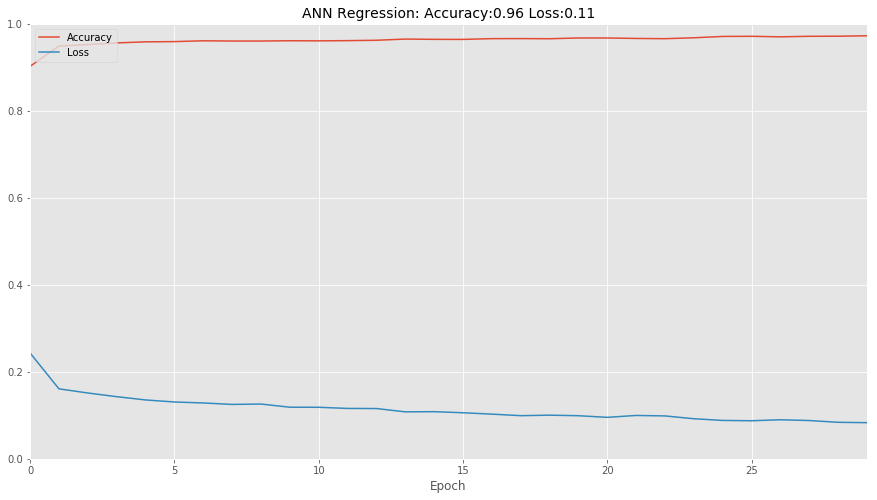

In [0]:
plotTrainingHist(deep_history, 30, 'ANN Regression')

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      2976
           1       0.66      0.47      0.55       924

   micro avg       0.82      0.82      0.82      3900
   macro avg       0.75      0.70      0.72      3900
weighted avg       0.80      0.82      0.81      3900

3900/3900 [==============================] - 0s 22us/step


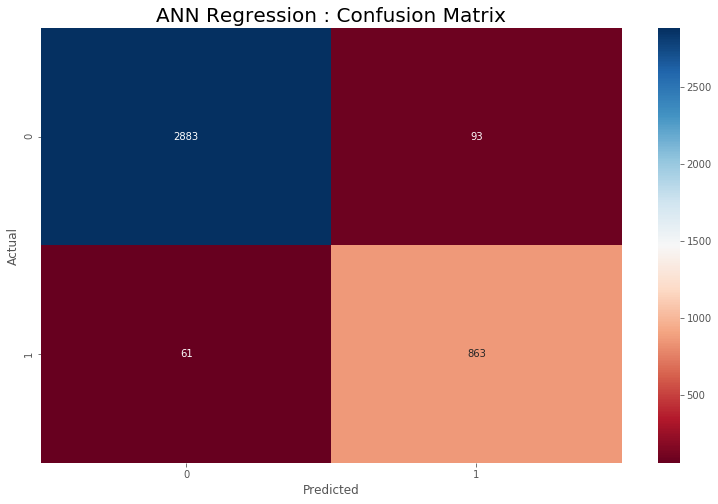

In [0]:
confMatrix(X_test, y_test, deep_model, 'ANN Regression')

## Improving the ANN Model


### 1.   Train the model for longer (increase the number of epochs).

In [0]:
# Increasing the # of Epochs
deep_model = Sequential()
deep_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='tanh'))
deep_model.add(Dense(16, activation='tanh'))
deep_model.add(Dense(1, activation='sigmoid'))
deep_model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])
deep_history = deep_model.fit(X_train, y_train, verbose=0, epochs=30)

In [0]:
# Checking relationship between Epochs & Accuracy
plt.figure(figsize=(15,8))

epochs_list = [30, 60, 90, 120, 240]
tab_cnt=0

for epochs in epochs_list:
  deep_history = deep_model.fit(X_train, y_train, verbose=0, epochs=30)
  print("Epoch: %f" % epochs)
  print("Accuracy: %f" % round(np.mean(deep_history.history['acc']),2))

Epoch: 30.000000
Accuracy: 1.000000
Epoch: 60.000000
Accuracy: 1.000000
Epoch: 90.000000
Accuracy: 1.000000
Epoch: 120.000000
Accuracy: 1.000000
Epoch: 240.000000
Accuracy: 1.000000


<Figure size 1080x576 with 0 Axes>

#### The longer the time, the more accurate the model is.
The figure belows shows that at Epoch =120, Accuracy reached about 98% compared to 96% in the previous model. 

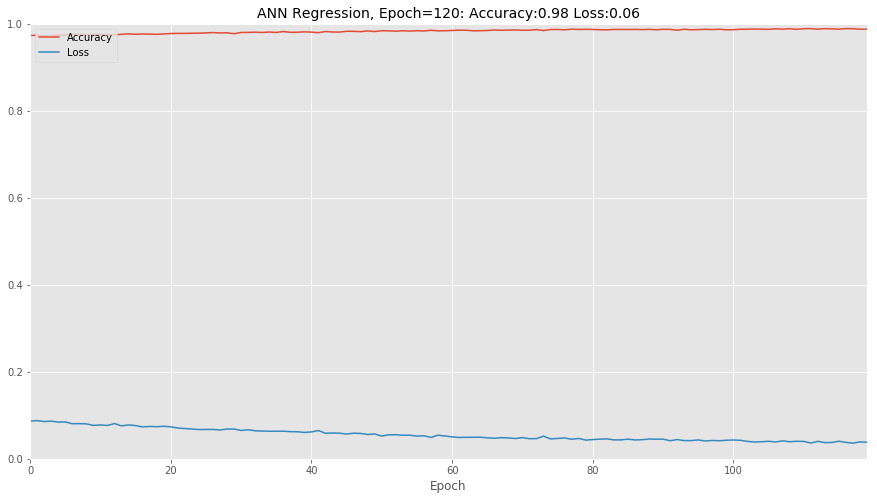

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      2976
           1       0.66      0.47      0.55       924

   micro avg       0.82      0.82      0.82      3900
   macro avg       0.75      0.70      0.72      3900
weighted avg       0.80      0.82      0.81      3900

3900/3900 [==============================] - 0s 29us/step


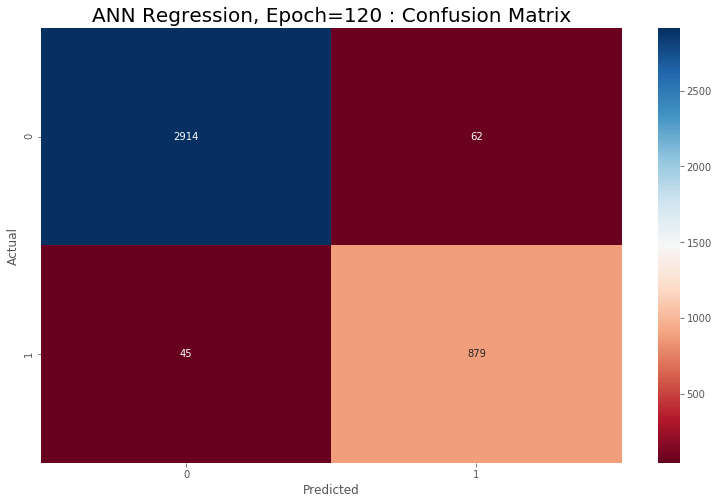

In [0]:
deep_history = deep_model.fit(X_train, y_train, verbose=0, epochs=120)
plotTrainingHist(deep_history, 120, 'ANN Regression, Epoch=120')
confMatrix(X_test, y_test, deep_model, 'ANN Regression, Epoch=120')

###2. Changing the Learning Rate

In [0]:
for lrate in np.arange(0.001, 1, 0.2):
    deep_model.compile(Adam(lr=lrate), 'binary_crossentropy', metrics=['accuracy'])
    deep_history = deep_model.fit(X_train, y_train, verbose=0, epochs=120)
    print("Learning Rate: %f" % lrate)
    print("Accuracy: %f" % round(np.mean(deep_history.history['acc']),2))
    print("Loss: %f" % round(np.mean(deep_history.history['loss']),2))

Learning Rate: 0.001000
Accuracy: 0.990000
Loss: 0.030000
Learning Rate: 0.201000
Accuracy: 0.760000
Loss: 3.850000
Learning Rate: 0.401000
Accuracy: 0.760000
Loss: 3.850000
Learning Rate: 0.601000
Accuracy: 0.760000
Loss: 3.850000
Learning Rate: 0.801000
Accuracy: 0.760000
Loss: 3.850000


#### The lesser the learning rate, the better the accuracy. 
The figure belows shows that at lr=0.001, Accuracy reached about 98% compared to 96% in the previous model. 

---

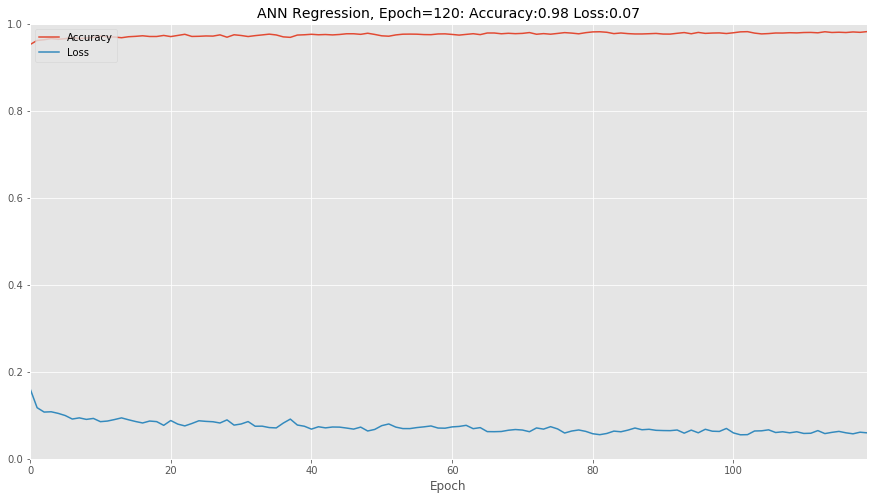

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      2976
           1       0.66      0.47      0.55       924

   micro avg       0.82      0.82      0.82      3900
   macro avg       0.75      0.70      0.72      3900
weighted avg       0.80      0.82      0.81      3900

3900/3900 [==============================] - 2s 470us/step


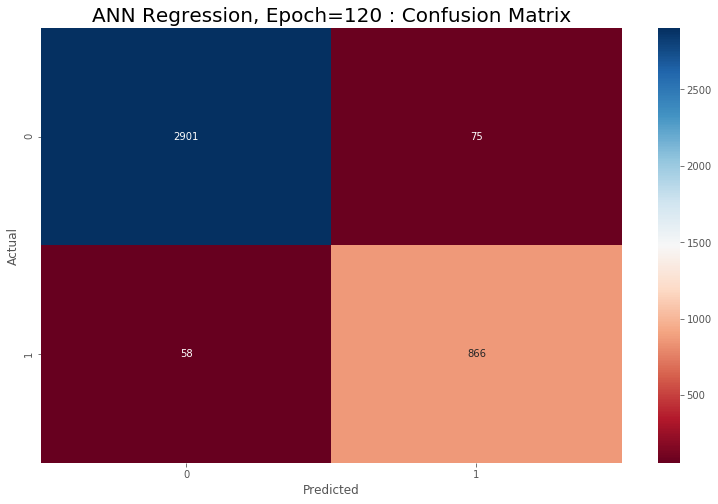

In [0]:
deep_model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])
deep_history = deep_model.fit(X_train, y_train, verbose=0, epochs=120)
plotTrainingHist(deep_history, 120, 'ANN Regression, Epoch=120')
confMatrix(X_test, y_test, deep_model, 'ANN Regression, Epoch=120')

### 3.   Use a different optimizer. (e.g. RMSprop)

#### RMSprop(learning_rate=0.001, rho=0.9) and activation = 'relu'

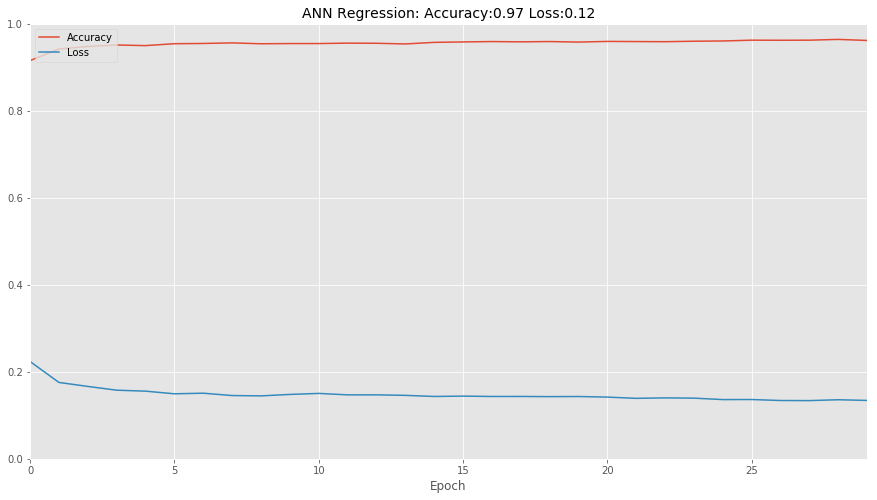

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      2976
           1       0.66      0.47      0.55       924

   micro avg       0.82      0.82      0.82      3900
   macro avg       0.75      0.70      0.72      3900
weighted avg       0.80      0.82      0.81      3900

3900/3900 [==============================] - 2s 471us/step


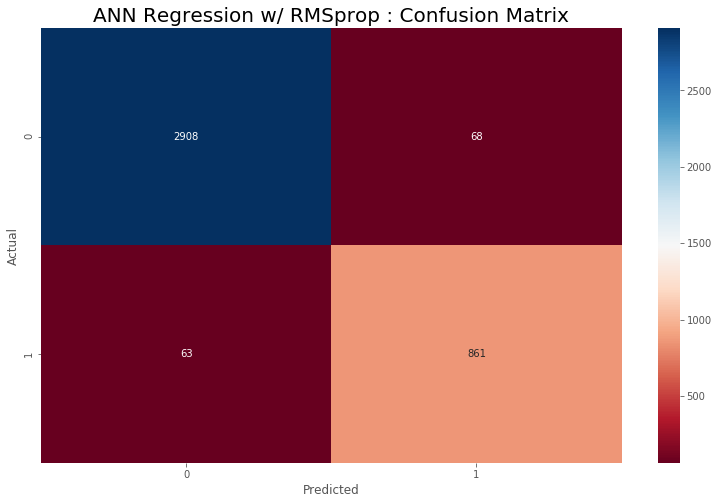

In [0]:
# RMSProp
from keras.optimizers import RMSprop

deep_model = Sequential()
deep_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
deep_model.add(Dense(16, activation='tanh'))
deep_model.add(Dense(1, activation='sigmoid'))
deep_model.compile(RMSprop(lr=0.01,rho=0.9), 'binary_crossentropy', metrics=['accuracy'])
deep_history = deep_model.fit(X_train, y_train, verbose=0, epochs=120)
plotTrainingHist(deep_history, 30, 'ANN Regression')
confMatrix(X_test, y_test, deep_model, 'ANN Regression w/ RMSprop')

### 4.   Increase the number of nodes per layer to 128 64 1

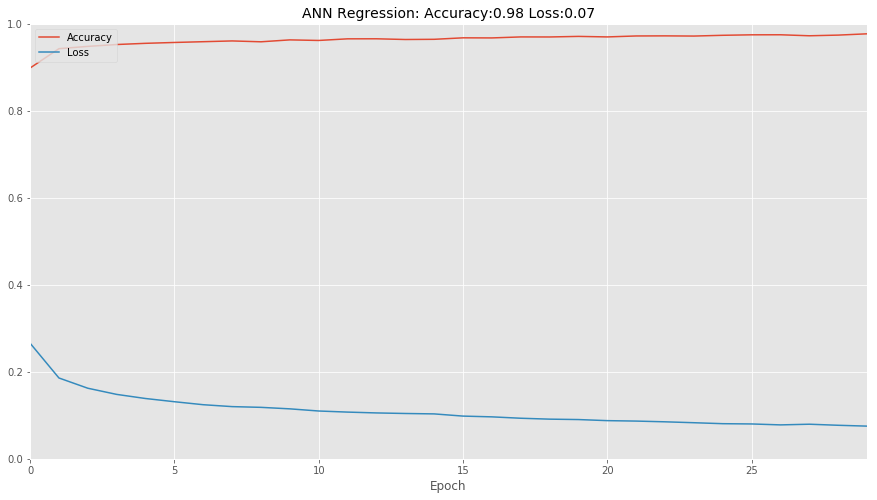

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      2976
           1       0.66      0.47      0.55       924

   micro avg       0.82      0.82      0.82      3900
   macro avg       0.75      0.70      0.72      3900
weighted avg       0.80      0.82      0.81      3900

3900/3900 [==============================] - 2s 454us/step


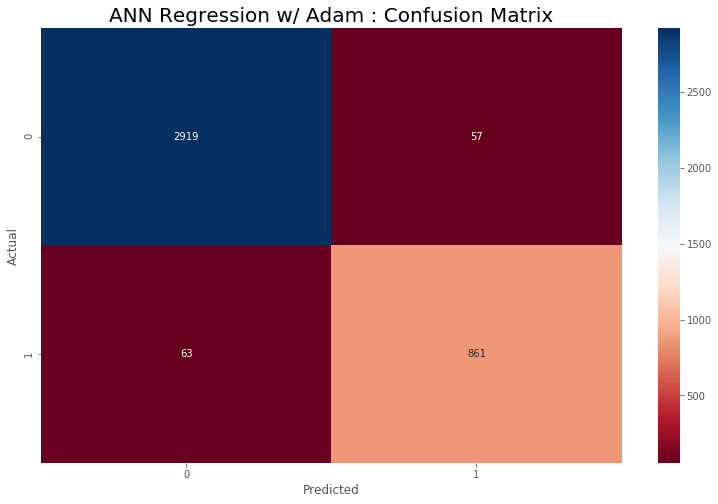

In [0]:
deep_model = Sequential()
deep_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
deep_model.add(Dense(64, activation='tanh'))
deep_model.add(Dense(1, activation='sigmoid'))
deep_model.compile(Adam(lr=0.001), 'binary_crossentropy', metrics=['accuracy'])
deep_history = deep_model.fit(X_train, y_train, verbose=0, epochs=90)
plotTrainingHist(deep_history, 30, 'ANN Regression')
confMatrix(X_test, y_test, deep_model, 'ANN Regression w/ Adam')

### 5.   Increase the number of layers to 128 64 32 16 1.

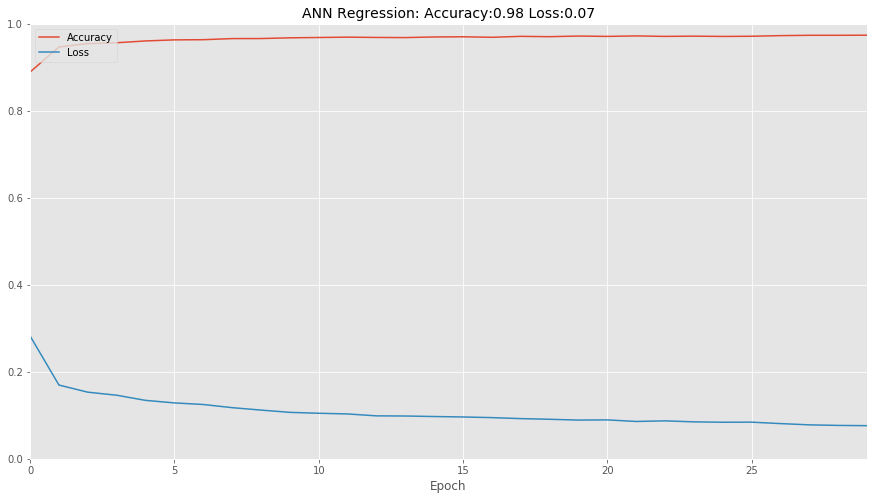

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      2976
           1       0.66      0.47      0.55       924

   micro avg       0.82      0.82      0.82      3900
   macro avg       0.75      0.70      0.72      3900
weighted avg       0.80      0.82      0.81      3900

3900/3900 [==============================] - 2s 499us/step


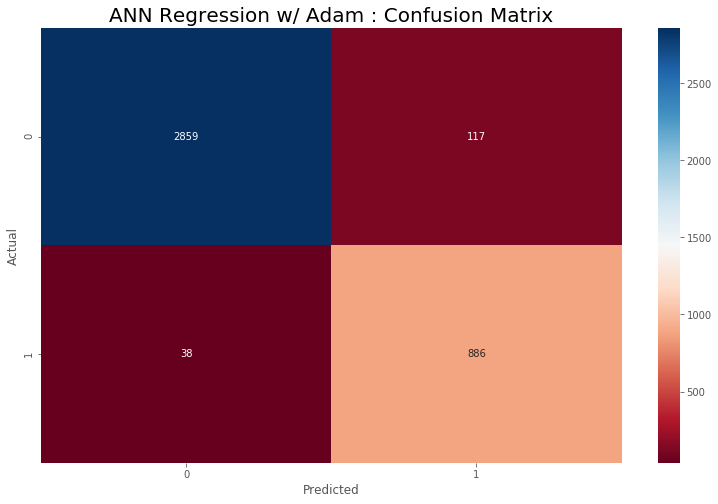

In [0]:
deep_model = Sequential()
deep_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
deep_model.add(Dense(64, activation='tanh'))
deep_model.add(Dense(32, activation='sigmoid'))
deep_model.add(Dense(16, activation='relu'))
deep_model.add(Dense(1, activation='sigmoid'))
deep_model.compile(Adam(lr=0.001), 'binary_crossentropy', metrics=['accuracy'])
deep_history = deep_model.fit(X_train, y_train, verbose=0, epochs=90)
plotTrainingHist(deep_history, 30, 'ANN Regression')
confMatrix(X_test, y_test, deep_model, 'ANN Regression w/ Adam')

#### Updating ANN Training Model
The figure belows shows that at lr=0.001, Accuracy reached about 98% compared to 96% in the previous model and loss reached at around 0.07. The precision matrix is as follows. 

---